In [12]:
# https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/
# https://colab.research.google.com/github/rpi-techfundamentals/website_spring_2020/blob/master/content/notebooks/20-deep-learning1/06-regression-bh-pytorch.ipynb#scrollTo=xD9PhAU7hoqT
!pip install torchvision
import numpy as np
import pandas as pd
import pyreadr
import scipy

In [8]:
import torch
print(torch.__version__)

1.6.0


In [24]:
TrainSet_eonr2_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/TrainSet_eonr2.rds")[None] # also works for RData
TrainSet_eonr2_df.head()

,eonr,rain_30,rain_60,rain_90,t_max_30,t_max_60,t_max_90,t_min_30,t_min_60,t_min_90,...,day_sow,day_v5,lai_v5,whc,oc_20cm_v5,sw_dep_v5,n_0_60cm_v5,surfaceom_wt_v5,sand_40cm,clay_40cm
0,190.0,125.0,229.0,17.0,22.050000,15.216667,8.250000,9.900000,3.533333,-4.633333,...,112.0,152.0,0.408,244.0,0.87775,666.043,39.3,444.3,4.0,24.571034
1,210.0,140.0,108.0,19.0,22.133333,15.933333,3.383333,10.300000,2.950000,-6.650000,...,112.0,147.0,0.402,244.0,0.88350,697.709,42.7,511.8,4.0,24.571034
2,200.0,63.0,52.0,26.0,21.733333,14.183333,6.750000,7.716667,1.550000,-3.666667,...,112.0,154.0,0.388,244.0,0.86900,670.037,21.2,84.1,4.0,24.571034
3,290.0,122.0,98.0,141.0,22.333333,15.033333,8.133333,11.050000,2.866667,-2.800000,...,112.0,148.0,0.308,244.0,0.88475,675.283,4.7,613.6,4.0,24.571034
4,160.0,103.0,171.0,77.0,20.333333,13.616667,3.450000,8.333333,2.900000,-5.066667,...,112.0,154.0,0.410,244.0,0.87900,690.324,41.4,408.2,4.0,24.571034


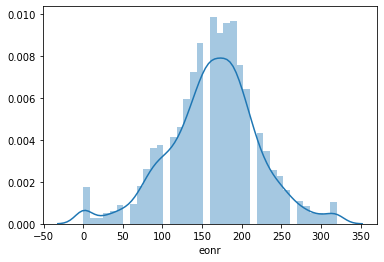

In [21]:
#Let's us seaborn, because it is pretty. ;) 
#See more here. http://seaborn.pydata.org/tutorial/distributions.html
import seaborn as sns
sns.distplot(TrainSet_eonr2_df['eonr']);

In [29]:
y_train = TrainSet_eonr2_df['eonr']
X_train = TrainSet_eonr2_df.drop('eonr', axis=1)
print(X_train.shape, y_train.shape)

(4456, 21) (4456,)


In [30]:
#Define training hyperprameters.
batch_size = 50
num_epochs = 200
learning_rate = 0.01
size_hidden= 100

#Calculate some other hyperparameters based on data.  
batch_no = len(X_train) // batch_size  #batches
cols=X_train.shape[1] #Number of columns in input matrix
n_output=1

In [31]:
#Create the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print("Executing the model on :",device)
class Net(torch.nn.Module):
    def __init__(self, n_feature, size_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(cols, size_hidden)   # hidden layer
        self.predict = torch.nn.Linear(size_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x
net = Net(cols, size_hidden, n_output)

Executing the model on : cuda:0


In [38]:
#Adam is a specific flavor of gradient decent which is typically better
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
criterion = torch.nn.MSELoss(size_average=False)  # this is for regression mean squared loss

/opt/anaconda3/envs/jupyter/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [36]:
X_train=X_train.values
y_train=y_train.values

In [39]:
from sklearn.utils import shuffle
from torch.autograd import Variable
running_loss = 0.0
for epoch in range(num_epochs):
    #Shuffle just mixes up the dataset between epocs
    X_train, y_train = shuffle(X_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.FloatTensor(X_train[start:end]))
        labels = Variable(torch.FloatTensor(y_train[start:end]))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print("outputs",outputs)
        #print("outputs",outputs,outputs.shape,"labels",labels, labels.shape)
        loss = criterion(outputs, torch.unsqueeze(labels,dim=1))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}'.format(epoch+1), "loss: ",running_loss)
    running_loss = 0.0


Epoch 1 loss:  183529258.28125
Epoch 2 loss:  14629157.53125
Epoch 3 loss:  13884297.0703125
Epoch 4 loss:  14370919.296875
Epoch 5 loss:  12586650.1171875
Epoch 6 loss:  14219631.046875
Epoch 7 loss:  13314448.53125
Epoch 8 loss:  13708126.5390625
Epoch 9 loss:  12942883.59375
Epoch 10 loss:  15460350.7421875
Epoch 11 loss:  12235865.8984375
Epoch 12 loss:  12629335.484375
Epoch 13 loss:  12315289.59375
Epoch 14 loss:  12809841.45703125
Epoch 15 loss:  12311251.359375
Epoch 16 loss:  11694269.2578125
Epoch 17 loss:  12917109.03515625
Epoch 18 loss:  11879055.4140625
Epoch 19 loss:  12696849.0234375
Epoch 20 loss:  13020705.84765625
Epoch 21 loss:  12225866.83984375
Epoch 22 loss:  11892622.4453125
Epoch 23 loss:  12651491.3828125
Epoch 24 loss:  10779717.359375
Epoch 25 loss:  11273471.1953125
Epoch 26 loss:  10831911.00390625
Epoch 27 loss:  10657268.19140625
Epoch 28 loss:  10446764.578125
Epoch 29 loss:  10736666.484375
Epoch 30 loss:  11287742.46875
Epoch 31 loss:  10380041.1875
E

In [41]:
#import pandas as pd
from sklearn.metrics import r2_score

X = Variable(torch.FloatTensor(X_train)) 
result = net(X)
pred=result.data[:,0].numpy()
print(len(pred),len(y_train))
r2_score(pred,y_train)

4456 4456


-0.33709912164422273